In [1]:
# Characterize somatic insertions

In [2]:
from collections import (
    defaultdict,
    namedtuple,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import seaborn as sns
import scipy.stats


PAIRS = {
    'KD-6-tumor': 'KD-6-head',
    'KD-8-tumor': 'KD-8-head',
    'BD-09-tumor': 'BD-9-head',
    'BD-10-tumor': 'BD-10-head'
}
PAIRS.update({v:k for k,v in PAIRS.items()})


COLUMNS = ['chrom', 'program', 'insertion', 'start', 'end', 'score', 'strand', 'idk', 'attributes']
insertion = namedtuple('Insertion', COLUMNS)

In [3]:
# PUTATIVE_INSERTIONS = '../../pre-processed-data/raw_insertion_calls/all_putative_germline_insertions.gff3'
PREFIX = 'Delta Somatic'
PUTATIVE_INSERTIONS = 'delta_somatic_insertions.gff3'

# COVERAGE_FILE = '../../pre-processed-data/raw_insertion_calls/coverage_over_germline_insertions.tsv'
COVERAGE_FILE = 'delta_coverage_somatic.tsv'
# ALL_INSERTIONS = 'all_delta_insertions.gff3'
ALL_INSERTIONS = PUTATIVE_INSERTIONS
# SOMATIC_DATA = ['../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_delta_guts.gff', '../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_delta_heads.gff']
SOMATIC_DATA = [PUTATIVE_INSERTIONS]
INSERTION_SUMMARY = f'{PREFIX} TSD insertions.tsv'
FINAL_TABLE = f'{PREFIX} table.tsv'
VAF_TABLE_NORMALIZED = f'{PREFIX} vaf table.tsv'

In [4]:
summary = namedtuple('summary', 'chrom start mate_support split_support nref vaf')


def read_insertions(path):
    all_inserts = defaultdict(list)
    with open(path) as in_fh:
        for line in in_fh:
            fields = line.split()
            chrom = fields[0]
            start = int(fields[3])
            attributes = dict(item.split("=") for item in fields[8].split(";"))
            mate_support = int(attributes['left_mate_count']) + int(attributes['right_mate_count'])
            total_support = int(attributes['total_left_count']) + int(attributes['total_right_count'])
            split_support = total_support - mate_support
            nref = int(attributes['nref'])
            vaf = total_support / (total_support + nref)
            all_inserts[attributes['ID']].append((summary(chrom, start, mate_support, split_support, nref, vaf)))
    return all_inserts

all_inserts = read_insertions(ALL_INSERTIONS)

In [5]:
def find_overlap_support(all_inserts, cluster_id, chrom, start):
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.mate_support, insert.split_support
    return 0, 0

def find_nref(all_inserts, cluster_id, chrom, start):
    # nref = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.nref
    return 0

def find_vaf(all_inserts, cluster_id, chrom, start):
    # vaf = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.vaf
    return 0

In [6]:
def summarize_overlaps(insertions):
    overlaps = set()
    cluster_ids = set()
    if not insertions:
        raise Exception('nope')
    for index, ins in enumerate(insertions):
        overlaps.add(ins.attributes['ID'].split('_')[0])
        cluster_ids.add(ins.attributes['ID'])
        for overlap in ins.attributes['overlaps'].split(','):
            if overlap:
                cluster_ids.add(overlap)
                overlaps.add(overlap.split('_')[0])
        is_somatic  = (ins.chrom, ins.start, ins.end, ins.insertion) in somatic
    return [index, ins.chrom, ins.start, ins.end, ins.insertion, ins.strand, is_somatic, len(overlaps), cluster_ids]


def get_insertions_by_coordinate(path):
    insertions_by_coordinate = defaultdict(list)
    with open(path) as fh:
        for line in fh:
            fields = line.strip().split('\t')
            fields[8] = dict(item.split("=") for item in fields[8].split(";"))
            ins = insertion(*fields)
            if ins.attributes['valid_TSD'] == 'True':
                insertions_by_coordinate[(ins.chrom, ins.start, ins.end, ins.insertion)].append(ins)
    return insertions_by_coordinate


insertions_by_coordinate = get_insertions_by_coordinate(PUTATIVE_INSERTIONS)


somatic = defaultdict(list)
for dataset in SOMATIC_DATA:
    somatic.update(get_insertions_by_coordinate(dataset))

somatic = {ins: summarize_overlaps(somatic[ins]) for ins in somatic}

In [7]:
len(insertions_by_coordinate)

110

In [8]:
possible_somatic = {k:v for k, v in insertions_by_coordinate.items() if sum(1 for _ in v if _.attributes['overlaps'].count(',') == 0) == len(v)}

In [9]:
len(possible_somatic)

110

In [10]:
possible_private = defaultdict(list)

for insertions in insertions_by_coordinate.values():
    for record in insertions:
        overlaps = [overlap.split('_')[0] for overlap in record.attributes['overlaps'].split(',')]
        if len(overlaps) == 2 and PAIRS[overlaps[0]] == overlaps[1] and record.attributes['valid_TSD'] == 'True':
            possible_private[(record.chrom, record.start, record.end, record.insertion)].append(record)

In [11]:
early_somatic = {k:v for k,v in possible_private.items() if len(v) == 1}

In [12]:
private = {k:v for k,v in possible_private.items() if len(v) == 2}

In [13]:
def merge_connected_clusters(shared_summary):
    new_summary = []
    n_insertions = len(shared_summary)
    skip = -1
    for i, s in enumerate(shared_summary):
        if not skip == i:
            if i < (n_insertions - 1):
                n_s = shared_summary[i + 1]
                if s[-1] & n_s[-1]:
                    s[-1] = s[-1].union(n_s[-1])
                    skip = i + 1
            s[-2] = len(set(overlap.split('_')[0] for overlap in s[-1]))
            new_summary.append(s)
    return new_summary

<AxesSubplot:xlabel='Number of samples with insertion', ylabel='Number of insertion'>

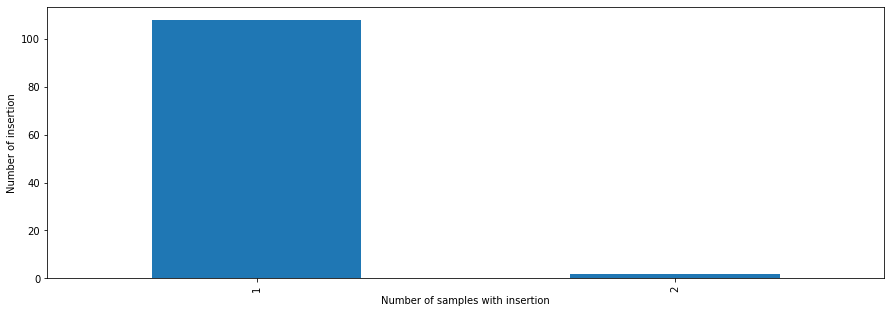

In [14]:
shared_germline = set(insertions_by_coordinate.keys()) - set(possible_somatic.keys()) - set(private.keys())
shared_summary = [summarize_overlaps(insertions_by_coordinate[ins]) for ins in insertions_by_coordinate]

# Make that a recursive call
new_summary = merge_connected_clusters(shared_summary)
new_summary = merge_connected_clusters(list(reversed(new_summary)))
new_summary = merge_connected_clusters(new_summary)
new_summary = list(reversed(merge_connected_clusters(list(reversed(new_summary)))))

shared_df = pd.DataFrame.from_records(shared_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'somatic', 'N_samples', 'overlaps',]
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion")

<AxesSubplot:xlabel='Number of samples with insertion, merge aggressively', ylabel='Number of insertion'>

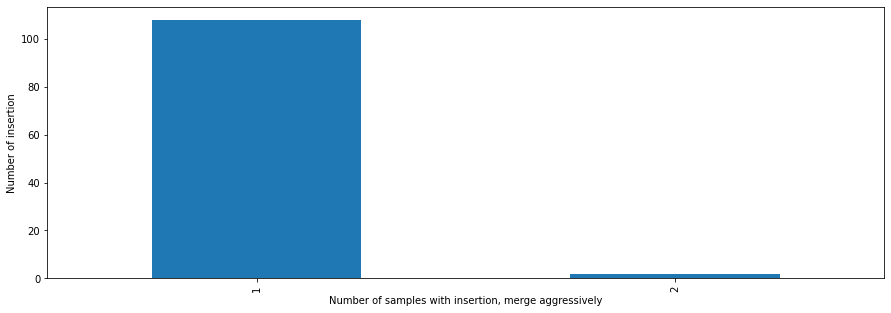

In [15]:
shared_df = pd.DataFrame.from_records(new_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'somatic', 'N_samples', 'overlaps']
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
# shared_df = shared_df[shared_df.somatic == False]
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively")

In [16]:
shared_df.somatic = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in somatic, axis=1)
shared_df['private'] = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in possible_private, axis=1)
shared_df.somatic.value_counts()
no_somatic = shared_df[shared_df.somatic == False]
if not no_somatic.empty:
    no_somatic.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively, no somatic insertions")

In [17]:
shared_df[(shared_df.somatic == False) & (shared_df.N_samples == 1)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private


In [18]:
shared_df.strand.value_counts()

+    110
Name: strand, dtype: int64

In [19]:
shared_df[(shared_df.somatic == False) & (shared_df.private == True)].insertion.value_counts()

Series([], Name: insertion, dtype: int64)

In [20]:
shared_df[(shared_df.somatic == False) & (shared_df.insertion == 'rover')].N_samples.value_counts()

Series([], Name: N_samples, dtype: int64)

In [21]:
shared_df[(shared_df.somatic == False) & (shared_df.insertion == 'rover') & (shared_df.N_samples == 68)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private


In [22]:
shared_df

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
0,0,Y,501595,501612,Tc3,+,True,1,{KD-8-tumor_325},"[(0, 2)]",[14],[0.125],False
1,0,Y,50331,50347,mdg1,+,True,1,{BD-10-tumor_34},"[(2, 10)]",[29],[0.2926829268292683],False
2,0,X,19297794,19297826,Rt1b,+,True,1,{KD-6-tumor_35},"[(0, 2)]",[11],[0.15384615384615385],False
3,0,X,19247074,19247085,jockey,+,True,1,{BD-10-tumor_26},"[(0, 2)]",[48],[0.04],False
4,0,X,18448482,18448487,roo,+,True,1,{KD-6-tumor_51},"[(1, 1)]",[27],[0.06896551724137931],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,2L,14892264,14892302,F-element,+,True,1,{KD-6-tumor_131},"[(1, 1)]",[63],[0.03076923076923077],False
106,0,2L,13127100,13127123,Stalker2,+,True,1,{KD-6-tumor_15},"[(0, 3)]",[101],[0.028846153846153848],False
107,0,2L,11209241,11209246,297,+,True,1,{BD-09-tumor_14},"[(0, 6)]",[44],[0.12],False
108,0,2L,11174969,11174974,297,+,True,1,{BD-09-tumor_12},"[(0, 2)]",[31],[0.06060606060606061],False


In [23]:
fully_penetrant = shared_df[shared_df.N_samples == 8]
x = fully_penetrant[['chrom', 'start', 'end', 'insertion']]
y = [insertions_by_coordinate[tuple(r)] for r in x.to_records(index=False)]

if not fully_penetrant.empty:
    # All support
    ratio = []
    x_insertions = []
    plt.figure()
    for insertions in y[50:]:
        for ins in insertions:
            if ins.attributes['genotype'] == 'heterozygous' and int(ins.score) > 15:
                if ins.chrom == 'X':
                    x_insertions.append(ins)
                    continue
                nref = int(ins.attributes['nref'])
                score = int(ins.score)
                ratio.append(score /  (score + nref))
    sns.boxplot(pd.Series(ratio), orient='v').set_title("Count all support")
    (np.percentile(ratio, q=1), np.percentile(ratio, q=99))
    # Mate support
    ratio = []
    plt.figure()
    for insertions in y[50:]:
        for ins in insertions:
            if ins.chrom == 'X':
                continue
            if ins.attributes['genotype'] == 'heterozygous' and int(ins.score) > 15:
                nref = int(ins.attributes['nref'])
                score = int(ins.attributes['left_mate_count']) + int(ins.attributes['right_mate_count'])
                ratio.append(score /  (score + nref))
    sns.boxplot(pd.Series(ratio), orient='v').set_title("Count only mate support")
    (np.percentile(ratio, q=1), np.percentile(ratio, q=99))

In [24]:
shared_df

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
0,0,Y,501595,501612,Tc3,+,True,1,{KD-8-tumor_325},"[(0, 2)]",[14],[0.125],False
1,0,Y,50331,50347,mdg1,+,True,1,{BD-10-tumor_34},"[(2, 10)]",[29],[0.2926829268292683],False
2,0,X,19297794,19297826,Rt1b,+,True,1,{KD-6-tumor_35},"[(0, 2)]",[11],[0.15384615384615385],False
3,0,X,19247074,19247085,jockey,+,True,1,{BD-10-tumor_26},"[(0, 2)]",[48],[0.04],False
4,0,X,18448482,18448487,roo,+,True,1,{KD-6-tumor_51},"[(1, 1)]",[27],[0.06896551724137931],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,2L,14892264,14892302,F-element,+,True,1,{KD-6-tumor_131},"[(1, 1)]",[63],[0.03076923076923077],False
106,0,2L,13127100,13127123,Stalker2,+,True,1,{KD-6-tumor_15},"[(0, 3)]",[101],[0.028846153846153848],False
107,0,2L,11209241,11209246,297,+,True,1,{BD-09-tumor_14},"[(0, 6)]",[44],[0.12],False
108,0,2L,11174969,11174974,297,+,True,1,{BD-09-tumor_12},"[(0, 2)]",[31],[0.06060606060606061],False


In [25]:
shared_df.somatic.value_counts()

True    110
Name: somatic, dtype: int64

In [26]:
shared_df.N_samples.value_counts()

1    108
2      2
Name: N_samples, dtype: int64

In [27]:
shared_df[(shared_df.somatic == True) & (shared_df.N_samples > 1)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
53,1,3L,15227866,15227891,opus,+,True,2,"{KD-8-tumor_17, BD-10-tumor_29}","[(2, 7), (4, 9)]","[90, 74]","[0.09090909090909091, 0.14942528735632185]",False
67,1,2R,20459725,20459750,HMS-Beagle,+,True,2,"{KD-8-tumor_28, BD-10-tumor_70}","[(3, 4), (3, 5)]","[84, 82]","[0.07692307692307693, 0.08888888888888889]",False


In [28]:
pretty_summary = shared_df[['chrom', 'start', 'end', 'insertion', 'somatic', 'private', 'N_samples', 'overlaps']]

In [29]:
pretty_summary.to_csv(INSERTION_SUMMARY, sep='\t', index=None)

In [30]:
pretty_summary

,chrom,start,end,insertion,somatic,private,N_samples,overlaps
0,Y,501595,501612,Tc3,True,False,1,{KD-8-tumor_325}
1,Y,50331,50347,mdg1,True,False,1,{BD-10-tumor_34}
2,X,19297794,19297826,Rt1b,True,False,1,{KD-6-tumor_35}
3,X,19247074,19247085,jockey,True,False,1,{BD-10-tumor_26}
4,X,18448482,18448487,roo,True,False,1,{KD-6-tumor_51}
...,...,...,...,...,...,...,...,...
105,2L,14892264,14892302,F-element,True,False,1,{KD-6-tumor_131}
106,2L,13127100,13127123,Stalker2,True,False,1,{KD-6-tumor_15}
107,2L,11209241,11209246,297,True,False,1,{BD-09-tumor_14}
108,2L,11174969,11174974,297,True,False,1,{BD-09-tumor_12}


In [31]:
coverage = pd.read_csv(COVERAGE_FILE, sep='\t')

final_table = pd.concat([shared_df, coverage], axis=1)
final_table['median_coverage'] = final_table.iloc[:, 10:].median(axis=1)


def high_and_low_support(list_of_tuples):
    support_one = sum(list_of_tuples[0])
    if len(list_of_tuples) == 1:
        return False
    support_two = sum(list_of_tuples[1])
    if min(support_one, support_two) < 3 and max(support_one, support_two) > 10:
        return True
    return False


final_table['early_developmental'] = (final_table['somatic'] == False) & (final_table['private'] == True) & (final_table['support'].apply(high_and_low_support))

In [32]:
final_table

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
0,0,Y,501595,501612,Tc3,+,True,1,{KD-8-tumor_325},"[(0, 2)]",...,31,5,33,35,19,38,43,23,31.0,False
1,0,Y,50331,50347,mdg1,+,True,1,{BD-10-tumor_34},"[(2, 10)]",...,51,36,55,69,42,70,65,56,55.0,False
2,0,X,19297794,19297826,Rt1b,+,True,1,{KD-6-tumor_35},"[(0, 2)]",...,54,22,57,50,44,68,63,52,52.0,False
3,0,X,19247074,19247085,jockey,+,True,1,{BD-10-tumor_26},"[(0, 2)]",...,81,44,68,97,79,73,71,68,71.0,False
4,0,X,18448482,18448487,roo,+,True,1,{KD-6-tumor_51},"[(1, 1)]",...,95,64,66,83,76,125,88,74,76.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,2L,14892264,14892302,F-element,+,True,1,{KD-6-tumor_131},"[(1, 1)]",...,38,39,27,29,39,38,32,30,32.0,False
106,0,2L,13127100,13127123,Stalker2,+,True,1,{KD-6-tumor_15},"[(0, 3)]",...,26,27,35,28,48,43,38,31,31.0,False
107,0,2L,11209241,11209246,297,+,True,1,{BD-09-tumor_14},"[(0, 6)]",...,45,18,41,42,46,28,38,34,38.0,False
108,0,2L,11174969,11174974,297,+,True,1,{BD-09-tumor_12},"[(0, 2)]",...,36,15,17,19,16,27,17,24,17.0,False


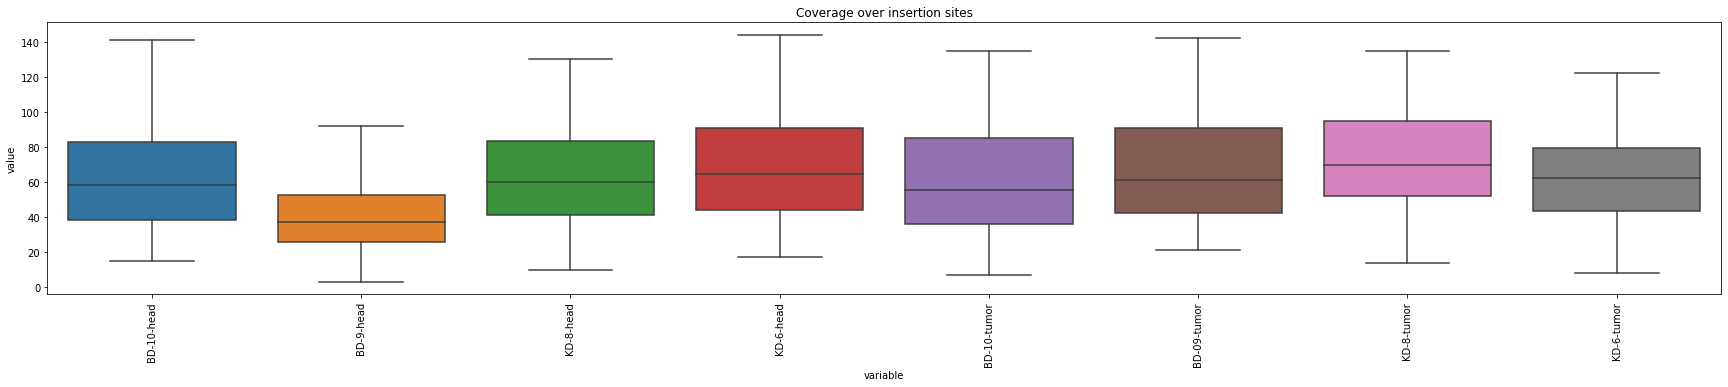

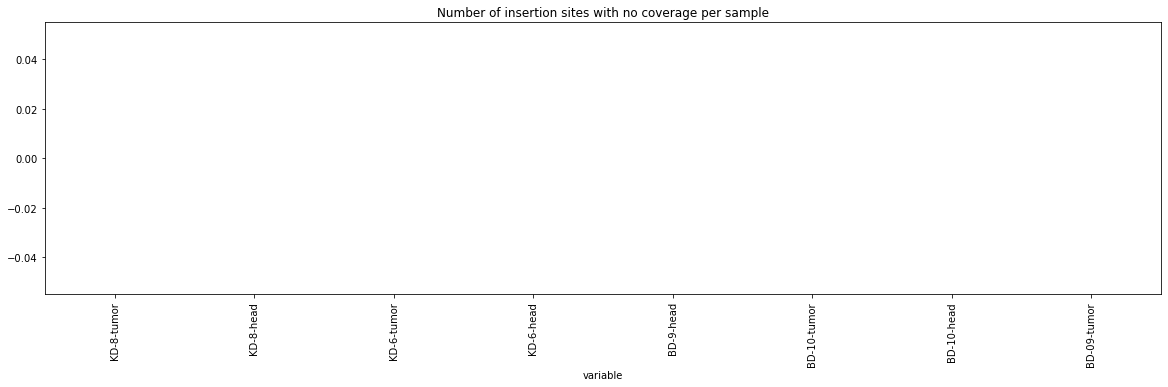

In [33]:
def plot_coverage_data(coverage_data):
    # Coverage over insertion sites
    fig, ax = plt.subplots(figsize=(30, 5))
    sns.boxplot(x='variable', y='value', showfliers = False, data=coverage_data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title('Coverage over insertion sites')
    
    # Insertion sites without coverage
    fig, ax = plt.subplots(figsize=(30, 5))
    germline_sites_without_coverage = coverage_data['value'].eq(0).astype(int).groupby(coverage_data['variable']).sum().sort_values(ascending=False)
    germline_sites_without_coverage.plot(kind='bar', x='sample', y='count', figsize=(20, 5), title='Number of insertion sites with no coverage per sample', ax=ax)

coverage_data = final_table.iloc[:, 13:-2].melt()
plot_coverage_data(coverage_data)

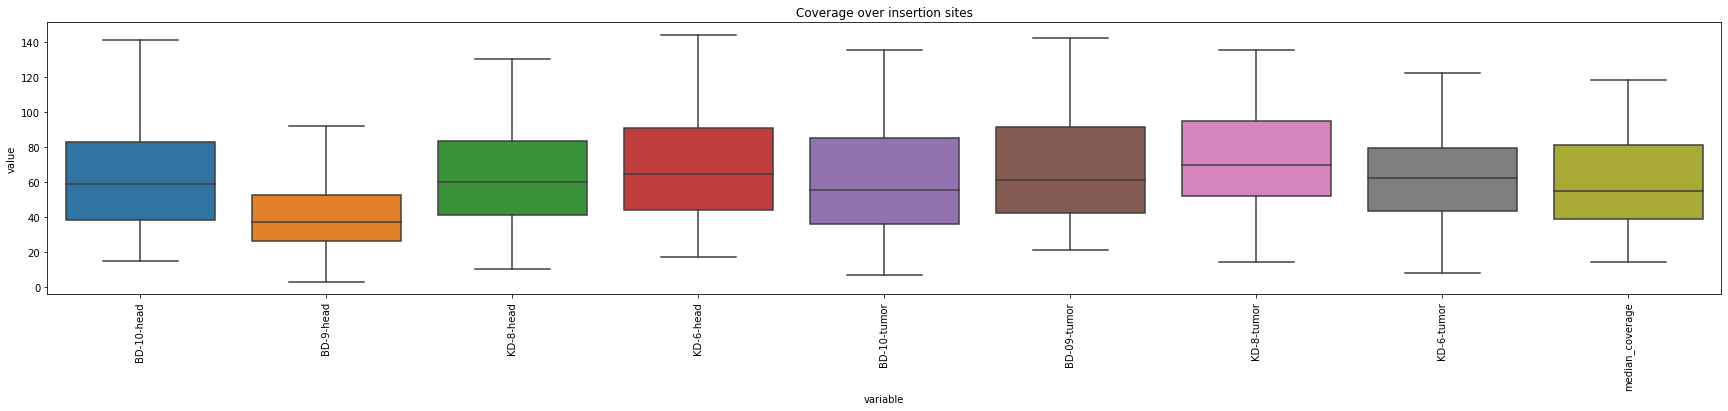

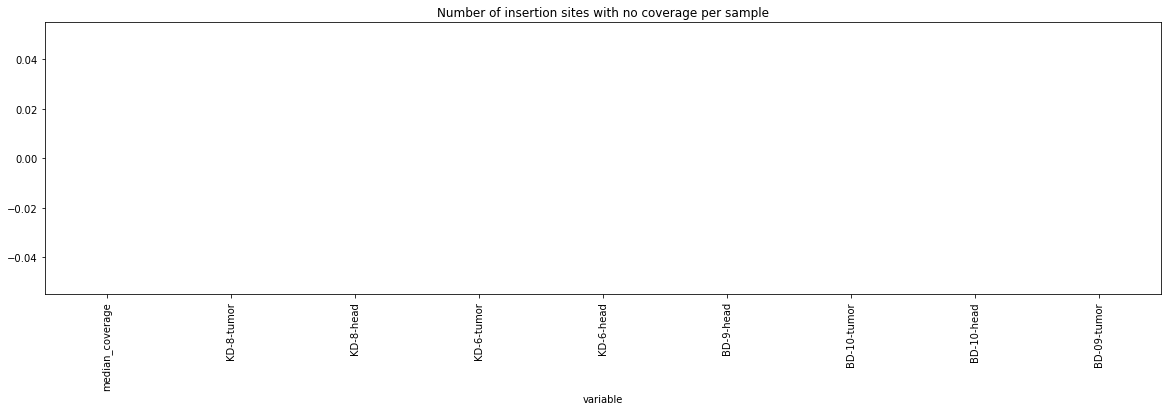

In [34]:
coverage_data = final_table[final_table.median_coverage >= 10].iloc[:, 13:-1].melt()
plot_coverage_data(coverage_data)

In [35]:
final_table

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
0,0,Y,501595,501612,Tc3,+,True,1,{KD-8-tumor_325},"[(0, 2)]",...,31,5,33,35,19,38,43,23,31.0,False
1,0,Y,50331,50347,mdg1,+,True,1,{BD-10-tumor_34},"[(2, 10)]",...,51,36,55,69,42,70,65,56,55.0,False
2,0,X,19297794,19297826,Rt1b,+,True,1,{KD-6-tumor_35},"[(0, 2)]",...,54,22,57,50,44,68,63,52,52.0,False
3,0,X,19247074,19247085,jockey,+,True,1,{BD-10-tumor_26},"[(0, 2)]",...,81,44,68,97,79,73,71,68,71.0,False
4,0,X,18448482,18448487,roo,+,True,1,{KD-6-tumor_51},"[(1, 1)]",...,95,64,66,83,76,125,88,74,76.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,2L,14892264,14892302,F-element,+,True,1,{KD-6-tumor_131},"[(1, 1)]",...,38,39,27,29,39,38,32,30,32.0,False
106,0,2L,13127100,13127123,Stalker2,+,True,1,{KD-6-tumor_15},"[(0, 3)]",...,26,27,35,28,48,43,38,31,31.0,False
107,0,2L,11209241,11209246,297,+,True,1,{BD-09-tumor_14},"[(0, 6)]",...,45,18,41,42,46,28,38,34,38.0,False
108,0,2L,11174969,11174974,297,+,True,1,{BD-09-tumor_12},"[(0, 2)]",...,36,15,17,19,16,27,17,24,17.0,False


In [36]:
final_table.to_csv(FINAL_TABLE, sep='\t', index=None)

In [37]:
final_table

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
0,0,Y,501595,501612,Tc3,+,True,1,{KD-8-tumor_325},"[(0, 2)]",...,31,5,33,35,19,38,43,23,31.0,False
1,0,Y,50331,50347,mdg1,+,True,1,{BD-10-tumor_34},"[(2, 10)]",...,51,36,55,69,42,70,65,56,55.0,False
2,0,X,19297794,19297826,Rt1b,+,True,1,{KD-6-tumor_35},"[(0, 2)]",...,54,22,57,50,44,68,63,52,52.0,False
3,0,X,19247074,19247085,jockey,+,True,1,{BD-10-tumor_26},"[(0, 2)]",...,81,44,68,97,79,73,71,68,71.0,False
4,0,X,18448482,18448487,roo,+,True,1,{KD-6-tumor_51},"[(1, 1)]",...,95,64,66,83,76,125,88,74,76.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,2L,14892264,14892302,F-element,+,True,1,{KD-6-tumor_131},"[(1, 1)]",...,38,39,27,29,39,38,32,30,32.0,False
106,0,2L,13127100,13127123,Stalker2,+,True,1,{KD-6-tumor_15},"[(0, 3)]",...,26,27,35,28,48,43,38,31,31.0,False
107,0,2L,11209241,11209246,297,+,True,1,{BD-09-tumor_14},"[(0, 6)]",...,45,18,41,42,46,28,38,34,38.0,False
108,0,2L,11174969,11174974,297,+,True,1,{BD-09-tumor_12},"[(0, 2)]",...,36,15,17,19,16,27,17,24,17.0,False


In [38]:
x = []
def expand_row(row):
    for sample, vaf in zip(row['overlaps'], row['vaf']):
        sample = sample.rsplit('_', 1)[0]
        coverage = row[sample]
        x.append((row['chrom'], row['start'], row['end'], row['insertion'], sample, coverage, vaf))

final_table.apply(lambda row: expand_row(row), axis=1)
coverage_per_insertion = pd.DataFrame.from_records(x)
coverage_per_insertion.columns = ['chrom', 'start', 'end', 'insertion', 'sample', 'coverage', 'vaf']
coverage_per_insertion.to_csv(VAF_TABLE_NORMALIZED, sep='\t', index=None)
coverage_per_insertion

,chrom,start,end,insertion,sample,coverage,vaf
0,Y,501595,501612,Tc3,KD-8-tumor,43,0.125000
1,Y,50331,50347,mdg1,BD-10-tumor,42,0.292683
2,X,19297794,19297826,Rt1b,KD-6-tumor,52,0.153846
3,X,19247074,19247085,jockey,BD-10-tumor,79,0.040000
4,X,18448482,18448487,roo,KD-6-tumor,74,0.068966
...,...,...,...,...,...,...,...
107,2L,14892264,14892302,F-element,KD-6-tumor,30,0.030769
108,2L,13127100,13127123,Stalker2,KD-6-tumor,31,0.028846
109,2L,11209241,11209246,297,BD-09-tumor,28,0.120000
110,2L,11174969,11174974,297,BD-09-tumor,27,0.060606


LinregressResult(slope=-0.001852147642606387, intercept=0.30852302892320427, rvalue=-0.24153591017324888, pvalue=0.2915171496531606, stderr=0.0017071207805837258)

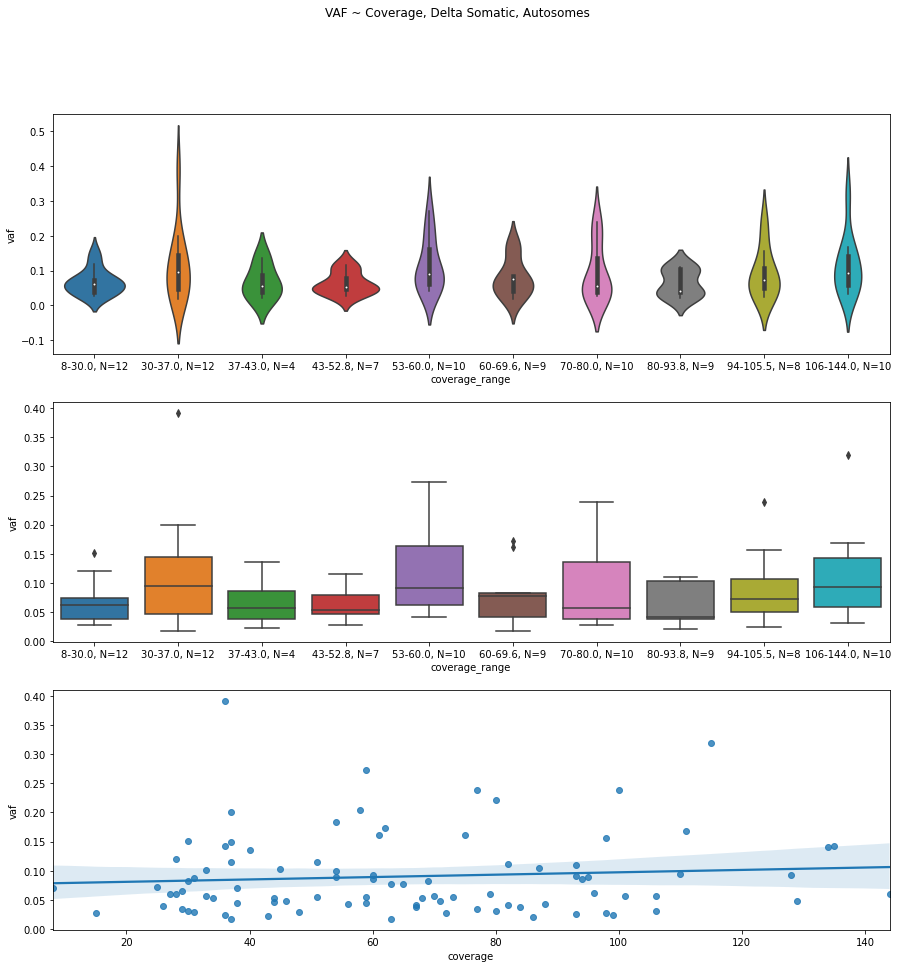

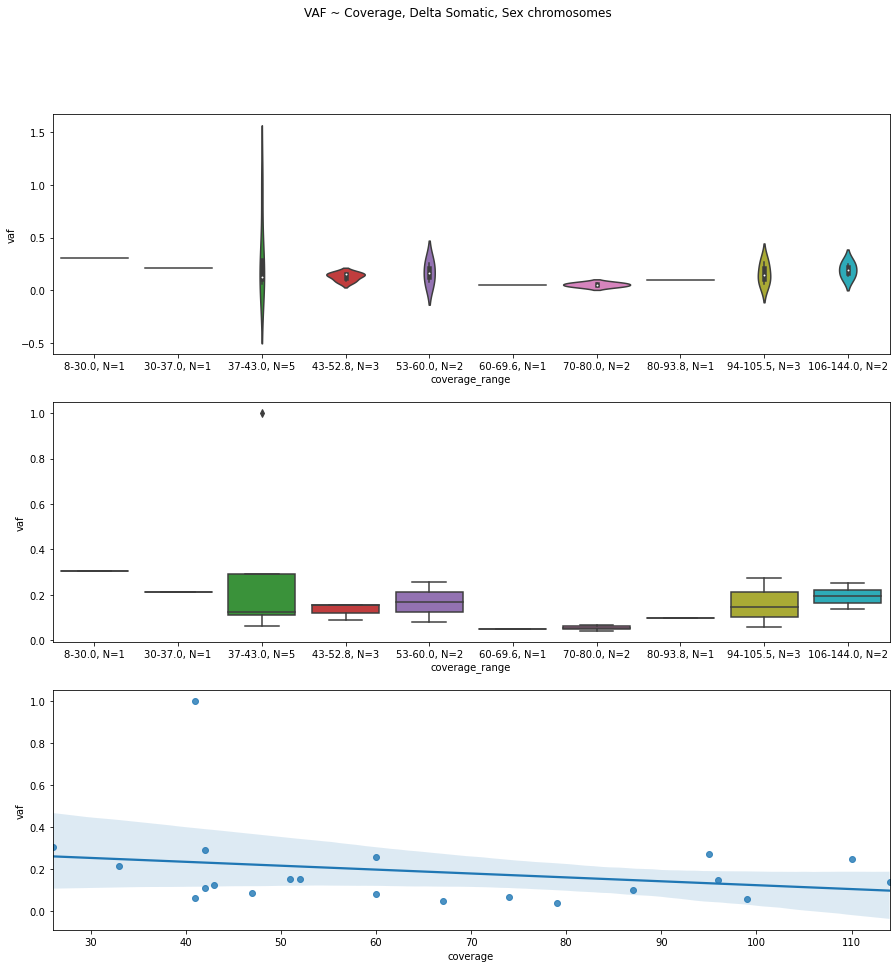

In [39]:
reasonable_coverage = coverage_per_insertion[(coverage_per_insertion.coverage >= 1) & (coverage_per_insertion.coverage <= 250)]
reasonable_coverage['coverage_range'] = pd.qcut(reasonable_coverage.coverage, q=10)
autosomes = reasonable_coverage[~reasonable_coverage['chrom'].isin({'X', 'Y'})]
sex_chromosomes = reasonable_coverage[reasonable_coverage['chrom'].isin({'X', 'Y'})]

def plot_coverage_vaf_relationship(df, title='Coverage-VAF relationship'):
    fig, axes = plt.subplots(nrows=3, figsize=(15, 15))
    fig.suptitle(title)
    sns.violinplot(x='coverage_range', y='vaf', data=df, ax=axes[0])
    sns.boxplot(x='coverage_range', y='vaf', data=df, ax=axes[1])
    xlabels = df.coverage_range.value_counts().sort_index().reset_index().apply(lambda row: f"{round(row['index'].left)}-{row['index'].right}, N={row['coverage_range']}", axis=1).to_list()
    axes[0].set_xticklabels(xlabels)
    axes[1].set_xticklabels(xlabels)
    sns.regplot(x='coverage', y='vaf', data=df, ax=axes[2])
    fig.savefig(f"{title}.pdf")
    return scipy.stats.linregress(df['coverage'], df['vaf'])


plot_coverage_vaf_relationship(autosomes, title=f'VAF ~ Coverage, {PREFIX}, Autosomes')
plot_coverage_vaf_relationship(sex_chromosomes, title=f'VAF ~ Coverage, {PREFIX}, Sex chromosomes')